# IMDB sentiment classification with GPT2 pre training
IMDB sentiment analysis is a good example to start with. in this notebook we will harness the power of mighty GPT2 with hep of HuggingFace and train a classifier with Keras only on 5K reviews.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras as keras # Nueral net Tensorflow high level API
import matplotlib.pyplot as plt # Visualization
import tensorflow as tf
import gc

In [0]:
! pip install transformers
! wget https://github.com/AminTaheri23/IMDB-sentiment-classification-GPT2/IMDB_Dataset.rar
! unzip IMDB_Dataset.rar

In [0]:
from transformers import GPT2Tokenizer, TFGPT2Model

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = TFGPT2Model.from_pretrained('gpt2')


In [0]:
imdb = pd.read_csv("./IMDB Dataset.csv")
imdb.shape

(50000, 2)

In [0]:
from sklearn import preprocessing
import re 

label_encoder = preprocessing.LabelEncoder()
imdb['sentiment'] = label_encoder.fit_transform(imdb['sentiment'])

imdb.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## removing html tags from data 

In [0]:
import re
cleanr = re.compile('<.*?>')

def cleanhtml(raw_html):
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

cleanhtml(". <br /><br />The.")

'. The.'

In [0]:
imdb.review = imdb.review.apply((lambda x: cleanhtml(x)))

In [0]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Cutting first 5K reviews

In [0]:
petit = imdb[:5000]

In [0]:
petit

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
4995,An interesting slasher film with multiple susp...,0
4996,i watched this series when it first came out i...,1
4997,Once again Jet Li brings his charismatic prese...,1
4998,"I rented this movie, after hearing Chris Gore ...",0


## max len of sequence?
we don't use max len of sequences because the other sequences will be padded very much and it will cost us low performance

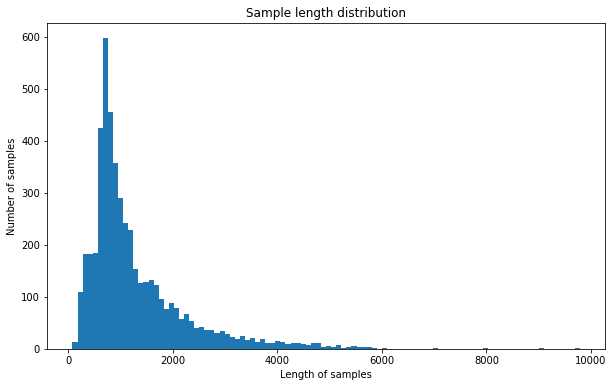

In [0]:
# TODO : Fix the plot (it is showing character numbers in each review 😢 )
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(petit['review'])], 100)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

## Tokenizing 
This may take a little while

In [0]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right' #stated in hugging faces docs
dic = tokenizer.batch_encode_plus(petit.review, add_special_tokens=True, max_length = 1023, pad_to_max_length=True)

In [0]:
gc.collect() #garbage collector for better RAM managment 

In [0]:
inp = np.asanyarray(dic['input_ids'])
att = np.asanyarray(dic['attention_mask'])

## We don't have CLS token!

what his cls token? it is a token for classification. Bert have this token and it is retrienved from a pooling and some other funtions such as sigmoid or tc. it is not precisely said in the paper (if you found it please show me so i can edit this). some other folks in github found that it is ok to average each word vector to make and classifiaction toke. so we are doing this here.

In [0]:
outputs = []
for i in range(0, 5000, 10):
  [output,_]  = model({'input_ids' : inp[i:i+10], 'attention_mask' : att[i:i+10]})
  outputs.append(output)
  gc.collect()

In [0]:
sen_emb = []
for j in range(500):
  for i in range(10):
    sen_emb.append(np.average(outputs[j][i], axis=0))

In [0]:
sen_emb = np.asarray(sen_emb) 

In [0]:
sen_emb.shape

(5000, 768)

## MLP model creation

In [0]:
classify = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='tanh', input_shape=(768,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classify.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
classify.summary()

In [0]:
sa = np.asarray(petit.sentiment)

In [ ]:
from sklearn import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sen_emb, sa, test_size=0.20)

In [0]:
history = classify.fit(x = X_train,
                       y = y_train,
                       validation_split=0.20,
                       epochs=40)

In [0]:
classify.test_on_batch(X_test, y_test, reset_metrics=True)

[0.3362675607204437, 0.8729166388511658]

In [0]:
# [0.3362675607204437, 0.8729166388511658] for [loss, accuracy] for mlp

## Regression model with grid search

In [0]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import train_test_split

min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(sen_emb)
X_train, X_test, y_train, y_test = train_test_split(X_minmax, sa, test_size=0.20)

parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

In [0]:
lr_clf = LogisticRegression(C=5.2, max_iter=3000)
lr_clf.fit(X_train, y_train)

In [0]:
lr_clf.score(X_test, y_test)

0.8945833333333333

# IMDB without pretraining

In [0]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras import regularizers
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
# create the model
model = Sequential()
model.add(Embedding(top_words, 16, input_length=max_words))
model.add(Flatten())
model.add(Dropout(0.7))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

adam = Adam()#lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
# Fit the model
model.fit(X_train[:2800], y_train[:2800], validation_data=(X_test[:200], y_test[:200]), epochs=40, batch_size=256, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# refrences 

* Base notebook https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

* imdb without training https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/ 

* gpt 2 docs from hugging face (and it's pre train) https://huggingface.co/transformers/model_doc/gpt2.html

* kaggle data sets from https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

* jay alammar blog for visualizing gpt2 http://jalammar.github.io/illustrated-gpt2/

* a stack overflow for removing html tags from data set